> ## Update
> - 添加了利用临床数据，使用生存分析的方法根据 p 值选出最优的聚合簇数量
> - 将 clinical 数据中 OS.time 的NaN值替换为 last_contact_days_to 值
> - 绘制 p_value - k 图



## 1. 数据预处理

### 1.1 数据加载

In [1]:
import pandas as pd

# 选取 gene_expression, DNA methylation(450k), miRNA expression 数据
gene_expression_raw_data = pd.read_csv('data/gene_expression/batch_effects_normalized_mRNA_data', sep='\t', index_col=0, nrows=10000)
dna_methylation_450k_raw_data = pd.read_csv('data/DNA_methylation/DNA_methylation_450k', sep='\t', index_col=0, nrows=10000)
miRNA_expression_raw_data = pd.read_csv('data/miRNA_expression/batch_effects_normalized_miRNA_data', sep='\t', index_col=0, nrows=1000)


In [2]:
# 选取 clinical 数据
clinical_raw_data = pd.read_csv('data/clinical/phenotype_curated_clinical_data', sep='\t', index_col=0)

In [3]:
# 打印原始数据形状
gene_expression_raw_data.shape, dna_methylation_450k_raw_data.shape, miRNA_expression_raw_data.shape, clinical_raw_data.shape

((10000, 11069), (10000, 9664), (743, 10824), (12591, 33))

### 1.2 样本匹配

In [4]:
# 获取每个数据集的列名（样本 ID）
gene_expression_samples = set(gene_expression_raw_data.columns)
dna_methylation_samples = set(dna_methylation_450k_raw_data.columns)
miRNA_expression_samples = set(miRNA_expression_raw_data.columns)

clinical_samples = set(clinical_raw_data.index)

# 找到所有数据集中共有的样本 ID
common_samples = gene_expression_samples & dna_methylation_samples & miRNA_expression_samples & clinical_samples

common_samples = list(common_samples)

# 使用共有的样本 ID 来过滤每个数据集
gene_expression_data = gene_expression_raw_data[common_samples]
dna_methylation_data = dna_methylation_450k_raw_data[common_samples]
miRNA_expression_data = miRNA_expression_raw_data[common_samples]

clinical_data = clinical_raw_data.loc[common_samples]


In [5]:
# 查看过滤后的数据集形状
gene_expression_data.shape, dna_methylation_data.shape, miRNA_expression_data.shape, clinical_data.shape

((10000, 8920), (10000, 8920), (743, 8920), (8920, 33))

### 1.3 数据清洗

In [6]:
# 定义清理函数
def clean_data(data):
    data = data.dropna(axis=1, thresh=0.7*data.shape[0])
    data = data.apply(lambda row: row.fillna(row.mean()), axis=1)
    data = data.fillna(0)
    return data

# 清理每种数据
gene_expression_data = clean_data(gene_expression_data)
dna_methylation_data = clean_data(dna_methylation_data)
miRNA_expression_data = clean_data(miRNA_expression_data)

In [23]:
# 将 clinical 数据中 OS.time 的NaN值替换为 last_contact_days_to 值
clinical_data['OS.time'] = clinical_data['OS.time'].fillna(clinical_data['last_contact_days_to'])

In [24]:
# 检查是否包含NaN值
print("Gene Expression Data contains NaN:", gene_expression_data.isnull().values.any())
print("DNA Methylation 450K Data contains NaN:", dna_methylation_data.isnull().values.any())
print("miRNA Expression Data contains NaN:", miRNA_expression_data.isnull().values.any())

# 检查clinical的Os.time, vital_status是否包含NaN值
print("Clinical Data contains NaN in OS.time:", clinical_data['OS.time'].isnull().values.any())

Gene Expression Data contains NaN: False
DNA Methylation 450K Data contains NaN: False
miRNA Expression Data contains NaN: False
Clinical Data contains NaN in OS.time: False


### 1.4 数据标准化

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

gene_expression_data = pd.DataFrame(scaler.fit_transform(gene_expression_data), 
                                           index=gene_expression_data.index, columns=gene_expression_data.columns)
dna_methylation_data = pd.DataFrame(scaler.fit_transform(dna_methylation_data), 
                                       index=dna_methylation_data.index, columns=dna_methylation_data.columns)
miRNA_expression_data = pd.DataFrame(scaler.fit_transform(miRNA_expression_data), 
                                              index=miRNA_expression_data.index, columns=miRNA_expression_data.columns)


In [9]:
# 查看数据集形状
gene_expression_data.shape, dna_methylation_data.shape, miRNA_expression_data.shape

((10000, 8920), (10000, 8920), (743, 8920))

In [10]:
# # 转置便于后期处理 (列表示样本，行表示特征)
# gene_expression_data = gene_expression_data.T
# dna_methylation_data = dna_methylation_data.T
# miRNA_expression_data = miRNA_expression_data.T

In [11]:
# 查看数据集形状
gene_expression_data.shape, dna_methylation_data.shape, miRNA_expression_data.shape

((10000, 8920), (10000, 8920), (743, 8920))

## 2. 数据整合


### 2.1 数据降维

In [44]:
from sklearn.decomposition import PCA

# 使用 PCA 将每个数据集降维到 100 维
pca = PCA(n_components=200)
gene_expression_pca = pca.fit_transform(gene_expression_data.T)
dna_methylation_pca = pca.fit_transform(dna_methylation_data.T)
miRNA_expression_pca = pca.fit_transform(miRNA_expression_data.T)

In [45]:
import numpy as np

# 拼接特征
combined_data = np.concatenate((gene_expression_pca, dna_methylation_pca, miRNA_expression_pca), axis=1)


In [46]:
# 查看拼接后的数据集维度, 检查是否包含NaN值
combined_data.shape

(8920, 600)

## 3. 聚类分析


### 3.1 评估 (使用轮廓系数)

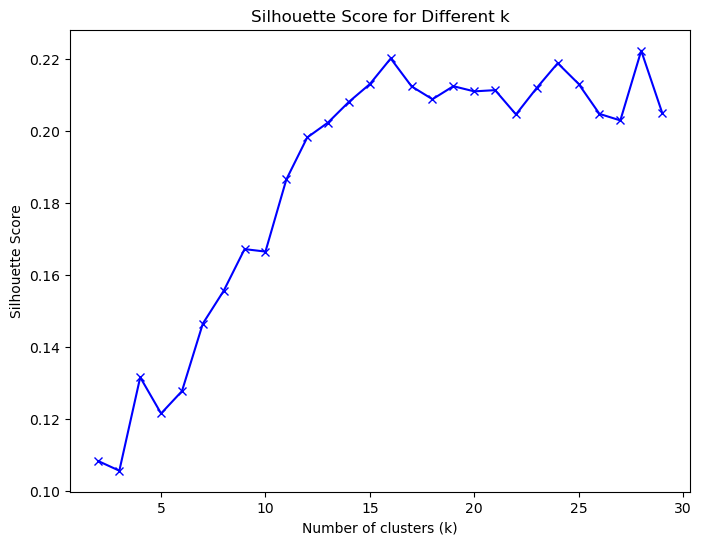

In [47]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 拼接降维后的数据集
combined_data = np.concatenate((gene_expression_pca, dna_methylation_pca, miRNA_expression_pca), axis=1)

# 寻找最优的簇数量
silhouette_scores = []
K = range(2, 30)  # 我们尝试从2到20个簇
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(combined_data)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(combined_data, labels)
    silhouette_scores.append(silhouette_avg)

# 可视化不同簇数量下的轮廓系数
plt.figure(figsize=(8, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.show()


Best number of clusters: 28


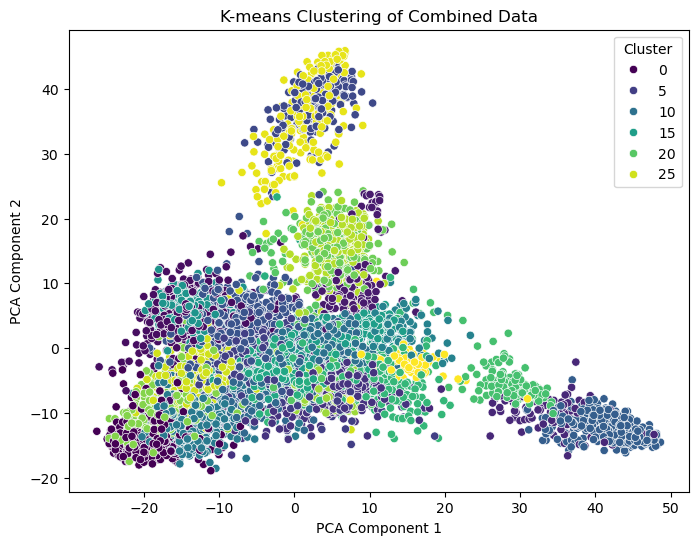

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# 选择最优簇数量并进行最终聚类
best_k = K[np.argmax(silhouette_scores)]
print(f'Best number of clusters: {best_k}')

kmeans = KMeans(n_clusters=best_k)
kmeans.fit(combined_data)
labels = kmeans.labels_

# 可视化聚类结果
plt.figure(figsize=(8, 6))
sns.scatterplot(x=combined_data[:, 0], y=combined_data[:, 1], hue=labels, palette='viridis')
plt.title('K-means Clustering of Combined Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

### 3.2 评估 (使用生存分析)

### 4.2 生存分析

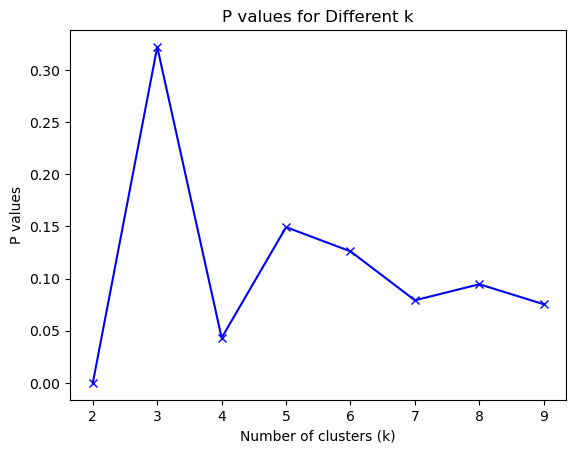

Optimal k: 2 with p-value: 1.5315073551178867e-26


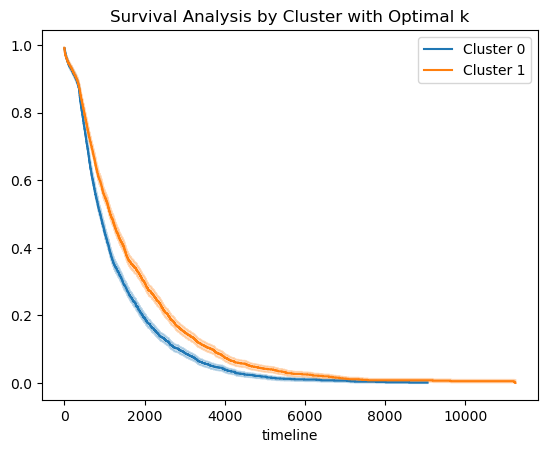

In [49]:
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_k_and_plot(survival_data, combined_data, k_range):
    optimal_k = None
    best_p_value = 1  # 初始化为最大的p值
    best_labels = None
    total_p_values = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(combined_data)
        
        survival_data['Cluster'] = labels
        kmf = KaplanMeierFitter()
        survival_curves = []

        for cluster in np.unique(labels):
            cluster_data = survival_data[survival_data['Cluster'] == cluster]
            T = cluster_data['OS.time']
            E = np.where(cluster_data['vital_status'] == 'Alive', 1, 0)
            kmf.fit(T, event_observed=E)
            survival_curves.append((T, E))
        
        # 计算不同聚类之间的生存曲线差异
        p_values = []
        for i in range(len(survival_curves) - 1):
            for j in range(i + 1, len(survival_curves)):
                result = logrank_test(survival_curves[i][0], survival_curves[j][0], event_observed_A=survival_curves[i][1], event_observed_B=survival_curves[j][1])
                p_values.append(result.p_value)
            
                
        # 选择差异最大（p值最小）的聚类结果
        min_p_value = np.mean(p_values) if p_values else 1
        total_p_values.append(min_p_value)
        if min_p_value < best_p_value:
            best_p_value = min_p_value
            optimal_k = k
            best_labels = labels
            
    # 可视化不同簇数量下的轮廓系数
    plt.plot(k_range, total_p_values, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('P values')
    plt.title('P values for Different k')
    plt.show()

    # 使用最优的k值进行聚类，并画出生存曲线图
    if optimal_k:
        print(f"Optimal k: {optimal_k} with p-value: {best_p_value}")
        survival_data['Cluster'] = best_labels
        kmf = KaplanMeierFitter()

        for cluster in np.unique(best_labels):
            cluster_data = survival_data[survival_data['Cluster'] == cluster]
            T = cluster_data['OS.time']
            E = np.where(cluster_data['vital_status'] == 'Alive', 1, 0)
            kmf.fit(T, event_observed=E, label=f'Cluster {cluster}')
            kmf.plot_survival_function()

        plt.title('Survival Analysis by Cluster with Optimal k')
        plt.show()
    else:
        print("No optimal k found.")


find_optimal_k_and_plot(clinical_data, combined_data, range(2, 10))